# Elise Hu: 2019 books

### Load Python tools 

In [1]:
import pandas as pd
import geopandas as gpd
from urllib.request import urlopen 
import pyarrow
import jenkspy
import matplotlib.pyplot as plt
%matplotlib inline
import json
import numpy as np
from altair import datum
import altair as alt
import altair_latimes as lat

In [2]:
alt.renderers.enable('notebook')
alt.themes.register('latimes', lat.theme)
alt.themes.enable('latimes')

ThemeRegistry.enable('latimes')

In [3]:
plt.rcParams['figure.figsize'] = (16,8)

In [4]:
pd.options.display.max_columns = 50
pd.options.display.max_rows = 1000
pd.options.display.float_format = '{:,.2f}'.format
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [5]:
src = pd.read_excel('input/elise-2019-books.xlsx')

In [6]:
src.dtypes

Order                            int64
Title                           object
Author                          object
Pages                            int64
URL                             object
gender                          object
type                            object
Subgenre                        object
Avg GoodReads Rating           float64
Started                 datetime64[ns]
date                    datetime64[ns]
Faves                           object
dtype: object

In [7]:
src.columns = src.columns.str.strip().str.lower().str.replace(' ', '_')\
                    .str.replace('(', '').str.replace(')', '').str.replace('-','_')

In [8]:
src['year'] = src['date'].dt.year.astype(str).str.replace('.0','',regex=False)

In [9]:
src['type'] = src['type'].str.replace(' ', '-')

In [10]:
src['days_to_read'] = src['date'] - src['started']

In [11]:
src['gender_description'] = src.gender.replace({'M': 'Male', 'F': 'Female'})

In [12]:
src.dtypes

order                             int64
title                            object
author                           object
pages                             int64
url                              object
gender                           object
type                             object
subgenre                         object
avg_goodreads_rating            float64
started                  datetime64[ns]
date                     datetime64[ns]
faves                            object
year                             object
days_to_read            timedelta64[ns]
gender_description               object
dtype: object

In [13]:
src['days_to_read'] = src['days_to_read'].dt.days

In [14]:
books = pd.DataFrame(src)

### Books by subgenre and month

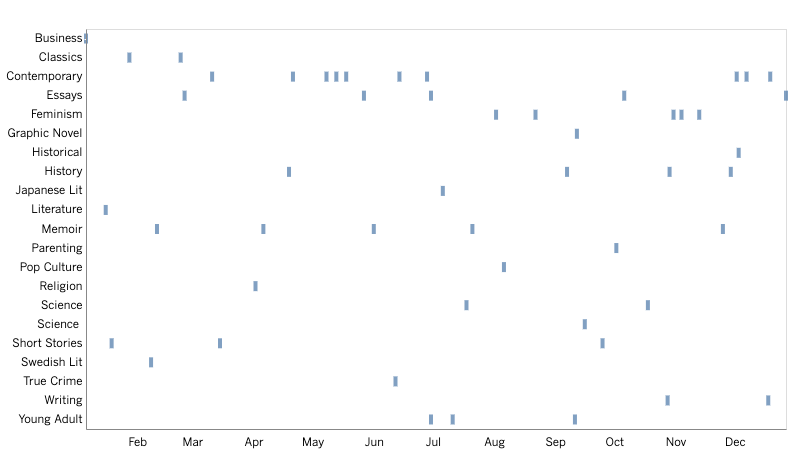

In [59]:
#DESKTOP
alt.Chart(books).mark_tick(thickness=4,size=10).encode(
    x=alt.X('date',axis=alt.Axis(tickCount=12, format='%b', tickColor='#ffffff'), title=''),
    y=alt.Y('subgenre',axis=alt.Axis(tickCount=0, tickColor='#ffffff'), title=' ')
).configure_axis(grid=False).properties(height=400, width=700)

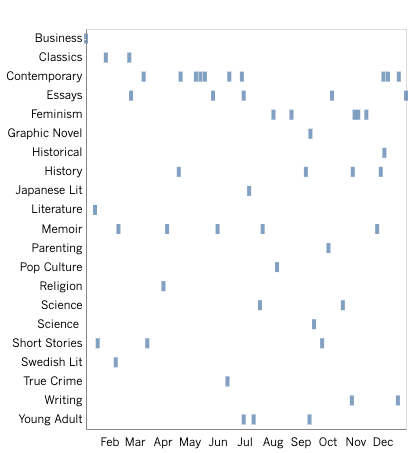

In [58]:
# mobile
alt.Chart(books).mark_tick(thickness=4,size=10).encode(
    x=alt.X('date',axis=alt.Axis(tickCount=12, format='%b', tickColor='#ffffff'), title=''),
    y=alt.Y('subgenre',axis=alt.Axis(tickCount=0, tickColor='#ffffff'), title=' ')
).configure_axis(grid=False).properties(height=400, width=320)

### Books by author gender and month

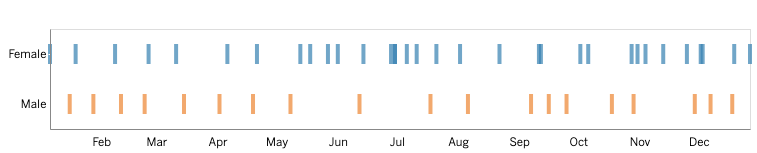

In [15]:
#DESKTOP
alt.Chart(books).mark_tick(thickness=4,size=20).encode(
    x=alt.X('date',axis=alt.Axis(tickCount=12, format='%b', tickColor='#ffffff'), title=''),
    y=alt.Y('gender_description',axis=alt.Axis(tickCount=0, tickColor='#ffffff'), title=' '),
    color=alt.Color('gender_description', legend=None)
).configure_axis(
    grid=False).properties(height=100, width=700)

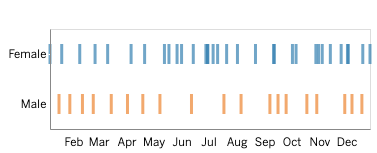

In [16]:
# MOBILE
alt.Chart(books).mark_tick(thickness=3,size=20).encode(
    x=alt.X('date',axis=alt.Axis(tickCount=12, format='%b', tickColor='#ffffff'), title=''),
    y=alt.Y('gender_description',axis=alt.Axis(tickCount=0, tickColor='#ffffff'), title=' '),
    color=alt.Color('gender_description', legend=None)
).configure_axis(
    grid=False).properties(height=100, width=320)

### Books by type and month

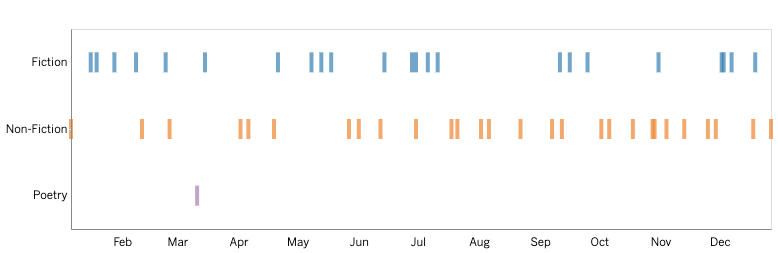

In [17]:
# DESKTOP 
alt.Chart(books).mark_tick(thickness=4,size=20).encode(
    x=alt.X('date',axis=alt.Axis(tickCount=12, format='%b', tickColor='#ffffff'), title=''),
    y=alt.Y('type',axis=alt.Axis(tickCount=0, tickColor='#ffffff'), title=' '),
    color=alt.Color('type', legend=None)
).configure_axis(
    grid=False).properties(height=200, width=700)

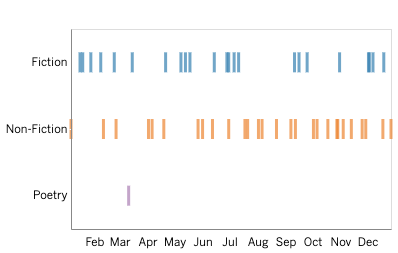

In [18]:
# MOBILE
alt.Chart(books).mark_tick(thickness=3,size=20).encode(
    x=alt.X('date',axis=alt.Axis(tickCount=12, format='%b', tickColor='#ffffff'), title=''),
    y=alt.Y('type',axis=alt.Axis(tickCount=0, tickColor='#ffffff'), title=' '),
    color=alt.Color('type', legend=None)
).configure_axis(
    grid=False).properties(height=200, width=320)

---

### No strong relationship between the number of pages and days to read

In [19]:
# Remove handful of books that took months to finish
books_month = books[books['days_to_read'] < 30]

In [20]:
books_corr = books_month[['pages', 'days_to_read']]

In [21]:
corr = books_corr.corr(method ='pearson')

In [22]:
print(corr)

              pages  days_to_read
pages          1.00          0.34
days_to_read   0.34          1.00


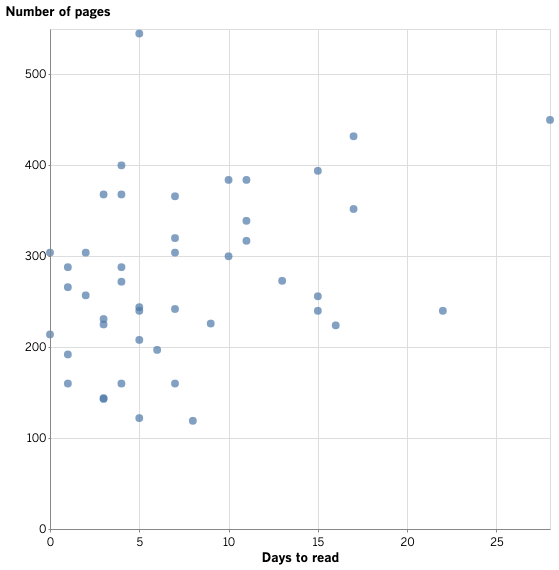

In [23]:
#DESKTOP 
alt.Chart(books_month).mark_circle(size=60).encode(
    x=alt.X('days_to_read:Q', title='Days to read', axis=alt.Axis(tickCount=6)),
    y=alt.Y('pages:Q', title='Number of pages', axis=alt.Axis(tickCount=5)),
    tooltip=['title:N', 'author:O', 'avg_goodreads_rating:Q', 'days_to_read:Q']
).properties(width=500, height=500)

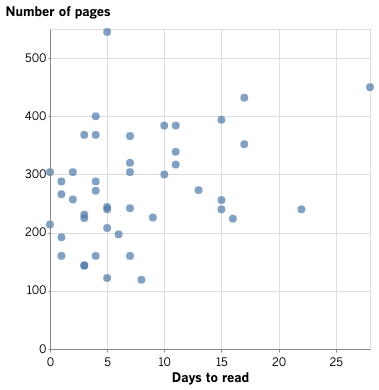

In [24]:
# MOBILE
alt.Chart(books_month).mark_circle(size=60).encode(
    x=alt.X('days_to_read:Q', title='Days to read', axis=alt.Axis(tickCount=6)),
    y=alt.Y('pages:Q', title='Number of pages', axis=alt.Axis(tickCount=5)),
    tooltip=['title:N', 'author:O', 'avg_goodreads_rating:Q', 'days_to_read:Q']
).properties(width=320, height=320)

---

In [25]:
books.head()

,order,title,author,pages,url,gender,type,subgenre,avg_goodreads_rating,started,date,faves,year,days_to_read,gender_description
0,1,Brotopia,Emily Chang,317,https://www.goodreads.com/book/show/36288143-b...,F,Non-Fiction,Business,4.04,2018-12-26,2019-01-06,NaN,2019,11,Female
1,2,The Human Stain,Philip Roth,384,https://www.goodreads.com/book/show/11734.The_...,M,Fiction,Literature,3.87,2019-01-06,2019-01-16,Y,2019,10,Male
2,3,You Know You Want This,Kristen Roupenian,225,https://www.goodreads.com/book/show/40539045-y...,F,Fiction,Short Stories,3.86,2019-01-16,2019-01-19,NaN,2019,3,Female
3,4,Why Buddhism is True,Robert Wright,336,https://www.goodreads.com/book/show/32895535-w...,M,Non-Fiction,Religion,4.05,2019-01-18,2019-04-02,NaN,2019,74,Male
4,5,If Beale Street Could Talk,James Baldwin,197,https://www.goodreads.com/book/show/38463.If_B...,M,Fiction,Classics,4.29,2019-01-22,2019-01-28,NaN,2019,6,Male


In [26]:
book_type = books.groupby(['type', 'year']).agg('size').reset_index(name='count').sort_values(by='count', ascending=False)
book_type.head()

,type,year,count
1,Non-Fiction,2019,28
0,Fiction,2019,23
2,Poetry,2019,1


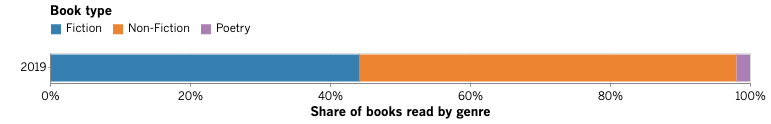

In [27]:
book_type_chart = alt.Chart(book_type).mark_bar().encode(
    x=alt.X('sum(count)', stack="normalize",  title='Share of books read by genre', \
            axis=alt.Axis(format='%',tickCount=6)),
    y=alt.Y('year',title=''),
    order=alt.Order(
      # Sort the segments of the bars by this field
      'type',
      sort='ascending'
    ),
    color=alt.Color('type', legend=alt.Legend(orient="top", title='Book type'))
)

(book_type_chart).properties(height=30,width=700)

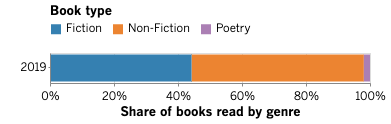

In [28]:
(book_type_chart).properties(height=30,width=320)

In [29]:
book_genre = books.groupby('subgenre').agg('size').reset_index(name='count')\
.sort_values(by='count', ascending=False)
book_genre.head()

,subgenre,count
2,Contemporary,10
10,Memoir,5
3,Essays,5
4,Feminism,5
7,History,4


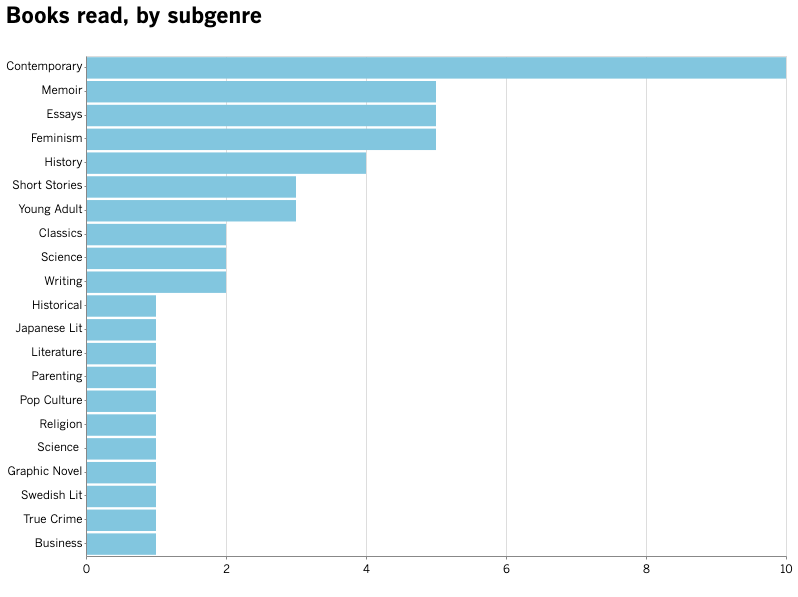

In [30]:
book_genre_chart = alt.Chart(book_genre).mark_bar().encode(
    y=alt.Y("subgenre:N", title=' ',
           sort=alt.EncodingSortField(
            field="count:Q",  # The field to use for the sort
            op="sum",  # The operation to run on the field prior to sorting
            order="ascending"  # The order to sort in
        )),
    x=alt.X("count:Q", title=' ', axis=alt.Axis(tickCount=6, format=''))
)

book_genre_chart.properties(height=500, width=700, title='Books read, by subgenre')

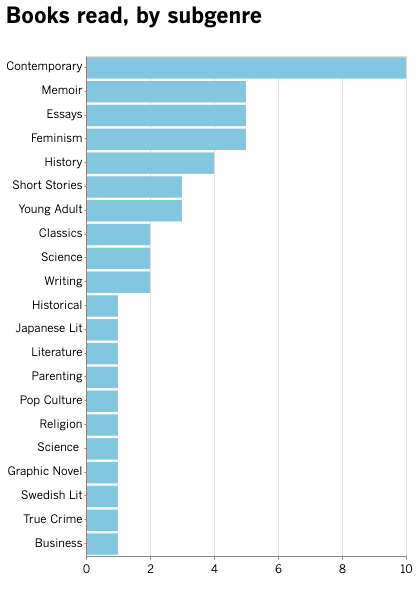

In [31]:
book_genre_chart.properties(height=500, width=320, title='Books read, by subgenre')

---

In [32]:
book_gender = books.groupby(['gender_description', 'year']).agg('size').reset_index(name='count').sort_values(by='count', ascending=False)
book_gender.head()

,gender_description,year,count
0,Female,2019,33
1,Male,2019,19


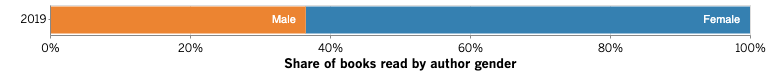

In [33]:
book_gender_chart = alt.Chart(book_gender).mark_bar().encode(
    x=alt.X('sum(count)', stack="normalize",  title='Share of books read by author gender',\
            axis=alt.Axis(format='%',tickCount=6)),
    y=alt.Y('year',title='',
            sort=alt.EncodingSortField(
            field="count:N",  # The field to use for the sort
            op="count",  # The operation to run on the field prior to sorting
            order="descending"  # The order to sort in)
            )),
    color=alt.Color('gender_description', legend=None)
)

book_gender_chart_text = book_gender_chart.mark_text(
    align='right',
    baseline='middle',
    dx=-10
).encode(text=alt.Text('gender_description'), 
    color=alt.condition(
        alt.datum.year == '2019',
        alt.value('white'),
        alt.value('white')
    )
)


(book_gender_chart + book_gender_chart_text).properties(height=30,width=700)

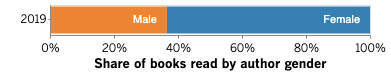

In [34]:
(book_gender_chart + book_gender_chart_text).properties(height=30,width=320)

---

### Page counts by subgenre

In [35]:
books.groupby(['subgenre']).agg({ 'pages': 'sum' }).reset_index()\
.sort_values(by='pages',ascending=False).head(10)

,subgenre,pages
2,Contemporary,2672
10,Memoir,1818
4,Feminism,1356
7,History,1186
3,Essays,1186
20,Young Adult,1088
14,Science,912
16,Short Stories,707
19,Writing,519
1,Classics,517


### Ratings by subgenre

In [36]:
books.groupby(['subgenre']).agg({ 'avg_goodreads_rating': 'mean' }).reset_index()\
.sort_values(by='avg_goodreads_rating',ascending=False).head(10)

,subgenre,avg_goodreads_rating
18,True Crime,4.48
5,Graphic Novel,4.30
14,Science,4.29
11,Parenting,4.26
19,Writing,4.23
1,Classics,4.19
13,Religion,4.05
0,Business,4.04
10,Memoir,4.03
7,History,4.02


### Favorite books by Goodreads rating

In [37]:
books_slim = books[['author', 'title', 'type', 'avg_goodreads_rating']][books['faves'] == 'Y']\
.sort_values(by='avg_goodreads_rating', ascending=False).head()

In [38]:
books_slim

,author,title,type,avg_goodreads_rating
41,Lori Gottlieb,Maybe You Should Talk to Somebody,Non-Fiction,4.40
25,Jia Tolentino,Trick Mirror,Non-Fiction,4.33
40,Adele Faber and Elaine Mazlish,How to Talk So Your Kids Will Listen,Non-Fiction,4.26
28,Taffy Brodesser-Akner,Fleishman Is In Trouble,Fiction,4.10
21,Leslie Jamison,The Recovering: Intoxication and its Aftermath,Non-Fiction,3.96


In [39]:
book_ratings = books.groupby(['type']).agg({'avg_goodreads_rating': 'mean'}).reset_index()

In [40]:
book_ratings

,type,avg_goodreads_rating
0,Fiction,3.79
1,Non-Fiction,4.07
2,Poetry,4.22


In [41]:
books_read_slow = books[['author', 'title', 'type', 'days_to_read']][books['faves'] == 'Y']\
.sort_values(by='days_to_read', ascending=False).head()

In [42]:
books_read_slow

,author,title,type,days_to_read
41,Lori Gottlieb,Maybe You Should Talk to Somebody,Non-Fiction,38
10,Bryan Washington,LOT,Fiction,15
25,Jia Tolentino,Trick Mirror,Non-Fiction,15
28,Taffy Brodesser-Akner,Fleishman Is In Trouble,Fiction,11
1,Philip Roth,The Human Stain,Fiction,10


In [43]:
books_read_fast = books[['author', 'title', 'type', 'days_to_read']][books['faves'] == 'Y']\
.sort_values(by='days_to_read', ascending=True).head()

In [44]:
books_read_fast

,author,title,type,days_to_read
15,Sally Rooney,Normal People,Fiction,1
24,Susan Choi,Trust Exercise,Fiction,2
47,Tara Conklin,The Last Romantics,Fiction,3
40,Adele Faber and Elaine Mazlish,How to Talk So Your Kids Will Listen,Non-Fiction,4
21,Leslie Jamison,The Recovering: Intoxication and its Aftermath,Non-Fiction,5


---